In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
#import random 
import scipy.integrate as spi
from scipy.integrate import solve_ivp
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
import warnings

In [2]:
%matplotlib inline
#suppress warnings
warnings.filterwarnings('ignore')

All Required Functions:

In [3]:
def ConstructAllData(T):
    p=pd.read_csv(T,delim_whitespace=True)
    df       = pd.DataFrame(p)
    df_OtherHalf = df.rename(columns={'x': 'y','y': 'x'})
    df_1stq=df.append(df_OtherHalf)
    df_2ndq=df_1stq.copy()
    df_2ndq.x=df_2ndq.x*-1
    df_3rdq=df_2ndq.copy()
    df_3rdq.y=df_3rdq.y*-1
    df_4thq=df_1stq.copy()
    df_4thq.y=df_4thq.y*-1
    df_Final=pd.concat([df_1stq, df_2ndq, df_3rdq,df_4thq],ignore_index=True)
    df_Final
    return df_Final


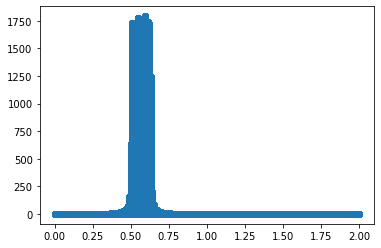

In [4]:
Quad="MagneticFieldFromQuad_ABSMagnetSystemGrid.txt"
SIM="MagneticFieldFromSIM_ABSMagnetSystemGrid.txt"
T_Quad=ConstructAllData(Quad)
T_SIM=ConstructAllData(SIM)
pr=pd.read_csv("MagneticFieldFromRing_ABSMagnetSystemGrid.txt",delim_whitespace=True)
T_Ring = pd.DataFrame(pr)
plt.scatter(T_Quad["z"],(T_SIM["Bx"]**2+T_SIM["By"]**2+T_SIM["Bz"]**2)**0.5)

In [5]:
def ObtainCorrespondingMagneticField(x0,v,t,T):
    xt=[x0[0]+(v[0]*t),x0[1]+(v[1]*t),x0[2]+(v[2]*t)]
    T["Del"]=(((T["x"]*100)-xt[0])**2+((T["y"]*100)-xt[1])**2+(T["z"]*100-xt[2])**2)**0.5
    b=T["Del"].idxmin()
    a=T["Del"].min()
    if a>1.1:
        print("Not working as expected")
    B=[T.iloc[b]["Bx"],T.iloc[b]["By"],T.iloc[b]["Bz"]]
    return B

20301 7879200 7879200


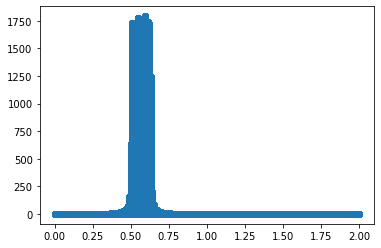

In [6]:
#plt.scatter((T_Ring["z"]-0.75)*-1,(T_Ring["Bz"]**2+T_Ring["Br"]**2)**0.5)
#plt.scatter(T_Quad["z"],(T_Quad["Bx"]**2+T_Quad["By"]**2+T_Quad["Bz"]**2)**0.5)
plt.scatter(T_SIM["z"],(T_SIM["Bx"]**2+T_SIM["By"]**2+T_SIM["Bz"]**2)**0.5)
T_Ring["Bz"].max()
T_Ring["Bz"].idxmax()
print(len(T_Ring),len(T_Quad),len(T_SIM))

In [7]:
x=[0.002,0.004,0.01]
v=[0,0,1]
t=1
ObtainCorrespondingMagneticField(x,v,t,T_SIM)

[7.32211666593134e-06, -7.3221166659313826e-06, -3.542547135906501e-21]

In [8]:
ObtainCorrespondingMagneticField(x,v,t,T_Quad)

[-0.0410452398497061, 0.0410452398497061, 0.0]

In [9]:
def ObtainCorreMagF_Ring(x0, v, t, T):
    xt=[x0[0]+(v[0]*t),x0[1]+(v[1]*t),x0[2]+(v[2]*t)]
    rt=(xt[0]**2+xt[1]**2)**0.5
    T["Del"]=(((T["r"]*100)-rt)**2+((T["z"]*100)-xt[2])**2)**0.5
    b=T["Del"].idxmin()
    a=T["Del"].min()
    if a>1.05:
        print("Not working as expected")
    Theta=math.atan2(xt[1],xt[0])
    Br=T.iloc[b]["Br"]
    Bz=T.iloc[b]["Bz"]
    B=Br*np.cos(Theta),Br*np.sin(Theta),Bz
    return B

In [10]:
ObtainCorreMagF_Ring(x, v, t, T_Ring)

(5.437236338392151e-08, 1.0874472676784299e-07, 0.0015356293870945)

In [11]:
def CombineCorrespondingMagneticField(x0,v,t,T_Quad,T_SIM,T_Ring):
    BQ=ObtainCorrespondingMagneticField(x0,v,t,T_Quad)
    BS=ObtainCorrespondingMagneticField(x0,v,t,T_SIM)
    BR=ObtainCorreMagF_Ring(x0, v, t, T_Ring)
    BT=[BQ[0]+BS[0]+BR[0],BQ[1]+BS[1]+BR[1],BQ[2]+BS[2]+BR[2]]
    return BT

In [12]:
CombineCorrespondingMagneticField(x,v,t,T_Quad,T_SIM,T_Ring)

[-0.04103786336067679, 0.041038026477766935, 0.0015356293870945]

In [13]:
def ObtainB0(x,T):
    T["Del"]=((T["x"]*100-x[0])**2+(T["y"]*100-x[1])**2+(T["z"]*100-x[2])**2)**0.5
    b=T["Del"].idxmin()
    a=T["Del"].min()
    if a>1.1:
        print("Not working as expected")
    B_Q=[T.iloc[b]["Bx"],T.iloc[b]["By"],T.iloc[b]["Bz"]]
    return B_Q

In [14]:
ObtainB0(x,T_SIM)

[9.694255531463276e-06, -9.694255531463276e-06, 0.0]

In [15]:
ObtainB0(x,T_Quad)

[-0.8878273365847746, 0.8878273365847746, 0.0]

In [16]:
def ObtainB0_Ring(x,T):
    rt=(x[0]**2+x[1]**2)**0.5
    T["Del"]=(((T["r"]*100)-rt)**2+((T["z"]*100)-x[2])**2)**0.5
    b=T["Del"].idxmin()
    a=T["Del"].min()
    if a>1.05:
        print("Not working as expected")
    Theta=math.atan2(x[1],x[0])
    Br=T.iloc[b]["Br"]
    Bz=T.iloc[b]["Bz"]
    B=[Br*np.cos(Theta),Br*np.sin(Theta),Bz]
    return B

In [17]:
 ObtainB0_Ring(x,T_Ring)

[-2.0828488214343668e-07, -4.1656976428687325e-07, 0.0014281018913727]

In [18]:
def CombineB0(x,T_Quad,T_SIM,T_Ring):
    BQ=ObtainB0(x,T_Quad)
    BS=ObtainB0(x,T_SIM)
    BR=ObtainB0_Ring(x,T_Ring)
    BT=[BQ[0]+BS[0]+BR[0],BQ[1]+BS[1]+BR[1],BQ[2]+BS[2]+BR[2]]
    return BT

In [19]:
CombineB0(x,T_Quad,T_SIM,T_Ring)

[-0.8878178506141253, 0.887817225759479, 0.0014281018913727]

In [20]:
#start work to calculate polarization
#intial parameters
g=20378.9; v3=22000;
z0=62.5;#initial position before exit of the quad
#z0=50;#try new one
r0=0.629;
z1=200;
r1=6.985;
num_points=2;
div=(r1+r0)/(z1-z0);
Pol=[]; 
r0=0.629;

KeyboardInterrupt: 

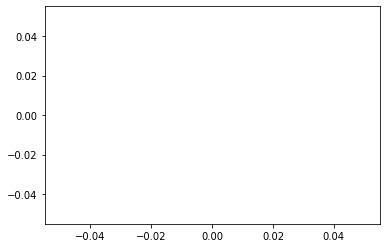

In [21]:
for n in range (1,num_points):
    
    phi = np.random.uniform(0,2*np.pi)
    rho=np.sqrt(np.random.uniform(0,1))*r0
    #rho=9999;
    #while (abs(rho)>r0):
    #    rho = np.random.normal(loc = 0, scale = 0.25, size = 1)*r0

    x0=[ rho*np.cos(phi), rho*np.sin(phi), z0 ];
    
    B0=CombineB0(x0,T_Quad,T_SIM,T_Ring);
    #obtain norm of the magnetic field
    B0t=np.linalg.norm(B0,axis=0);
    
    r=99999; 
    #make sure the generated values are within the radius of the pipe.
    while(r>r1):  
        ctheta=1-(1-np.cos(div))*np.random.uniform(0,1);
        v1=(v3*math.sqrt(1-pow(ctheta,2))*np.cos(phi), v3*math.sqrt(1-pow(ctheta,2))*np.sin(phi), v3*ctheta );
        x1=np.array(x0)
        v=np.array(v1)
        t1=(z1-z0)/v[2];
        x1=x0+(v*t1);
        #r=3;
        r2 = np.sqrt(x0[0]*x0[0] + x0[1]*x0[1]);
        r = np.sqrt(x1[0]*x1[0] + x1[1]*x1[1]);
    B1=CombineB0(x1,T_Quad,T_SIM,T_Ring);
    B1t = np.linalg.norm(B1,axis=0);
   
    #print(x1)
    #plt.scatter(B1[0],x1[1])
    t_i=0
    #print(t1)
    initial_int=0;
    final_int=101;
    B1x=[];
    B1y=[];
    B1z=[];
    T_i=[];
    for t in range (initial_int, final_int,1):
        step=t1/(final_int-initial_int-1) #difference time /difference in range
        ti=t*step
        x_i=x0+(v*ti)
        B_i=CombineB0(x_i,T_Quad,T_SIM,T_Ring);
        #print(B_i,x_i[2])
        T_i.append(ti)
        B1x.append(B_i[0])
        B1y.append(B_i[1])
        B1z.append(B_i[2])
    spl1 = UnivariateSpline(T_i,B1x)
    spl2 = UnivariateSpline(T_i,B1y)
    spl3 = UnivariateSpline(T_i,B1z)
    
    plt.plot(T_i, spl1(T_i), 'g', lw = 1)
    plt.plot(T_i, spl2(T_i), 'r', lw = 1)
    plt.plot(T_i, spl3(T_i), 'b', lw = 1)
    #spl.set_smoothing_factor(1e-5)
    #Now solve the differential equation
    
    #sol = solve_ivp(lambda t, y: g*np.cross(y,  CombineCorrespondingMagneticField(x0,v,t,T_Quad,T_SIM,T_Ring)), [0,t1], B0/B0t, method="RK45", rtol = 1e-5)
    sol = solve_ivp(lambda t, y: g*np.cross(y, [spl1(t),spl2(t),spl3(t)]), [0,t1], B0/B0t, method="RK45", rtol = 1e-5)
    
    #obtain last elemet of the array from the ode solution
    Mx=sol.y[0][-1]
    My=sol.y[1][-1]
    Mz=sol.y[2][-1]
    #norm of output vector of the ode
    Mn=np.sqrt(Mx**2+My**2+Mz**2)
    
    #polarization is given by 
    pol=(B1[0]*Mx+B1[1]*My+B1[2]*Mz)/(Mn*B1t)
    Pol.append(pol)
    #B1xnp=np.array(B1x)
    #df_B = pd.DataFrame() 
    #df_B['Bnp'] = B1xnp.tolist()
    #df_B=pd.Dataframe(B1xnp)
    #B1x_Interp=df_B['Bnp'].interpolate(method='spline',order=3)
    #B1x_Interp.plot()

In [ ]:
plt.hist(Pol,10,range=[-1.0,1.01]);
plt.ylim([0, 130])
plt.legend(["mean = "+str("{:.6f}".format(np.mean(Pol)))+" +/- "+str("{:.6f}".format(np.std(Pol)/np.sqrt(num_points))) ] )
plt.show